# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import curve_fit
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

![title](D:\GoogleDrive\retina\Chou's data\20210504\FIG\cSTA\fitNGD2Lparameter.tiff)

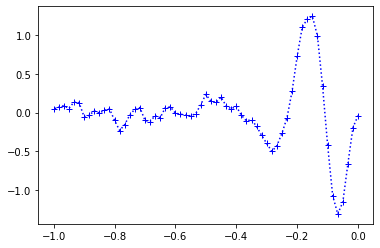

In [3]:
fig, ax = plt.subplots()
exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210504'
annots = loadmat(exp_folder+'\\merge\\merge_0224_cSTA_wf_3min_Q100_re', squeeze_me = True)
x = annots['bin_pos']
x = x-np.mean(x)
dt = 1/60
cn = 11-1

spike = annots['reconstruct_spikes'][cn]
rstate, _ = np.histogram(spike, np.arange(len(x)+1)*dt)
cSTA = np.correlate(x , rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
taxis = -np.arange(len(cSTA))*dt
ax.plot(taxis, cSTA, 'b+:')

# NGD1L

In [4]:
def NGD_TK(T, alpha, beta, g,  tau_y, Amp):
    dt = np.mean(np.diff(T))
    dt = 0.1*dt
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    y=np.zeros_like(x)
    z=np.zeros_like(x)
    w=np.zeros_like(x)
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j] + -x[j]-z[j] )
        dz=dt*(-beta *z[j]  + g*y[j] )
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
#     print(len(w), len(w[::10]))
    return Amp*y[::10]/(dt) #normalized by integration

In [5]:
def NGD_TK_AS(T, tau, omegastar, deltastar, tau_y, Bmp):
    dt = np.mean(np.diff(T))
    dt = 0.1*dt
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kt = -Bmp*np.exp(-T/tau)*np.cos(T*omegastar+deltastar)
    return np.convolve(x, Kt, 'full')[:len(T):10]

alpha: 15.355504261890191
beta : 0.687364844138721
g    : 751.620990199643
tau_y: 0.03642069788261841
Amp  : 5.286563395131292


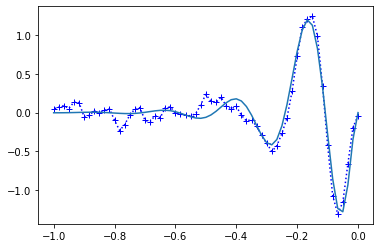

In [6]:
alpha, beta = 14.,1.2
g = 680.
tau_y = 0.03
Amp = 4
popt,pcov = curve_fit(NGD_TK, np.abs(taxis) , cSTA, p0=[alpha, beta, g,  tau_y, Amp],
                      bounds = ([0     , 0     , 0     , 0     , 0     ],
                                [np.inf, np.inf, np.inf, 0.6   , np.inf]) )
[alpha, beta, g,  tau_y, Amp] = popt
print('alpha:',alpha)
print('beta :',beta)
print('g    :',g)
print('tau_y:',tau_y)
print('Amp  :',Amp)
fit_cSTA = NGD_TK(np.abs(taxis), *popt).copy()
ax.plot(taxis, fit_cSTA)
fig

tau      : 0.12466598005517601
omegastar: 26.416517781588745
deltastar: 0.27081147641303255
tau_y    : 0.03642069788261841
Bmp      : 5.486524539893484


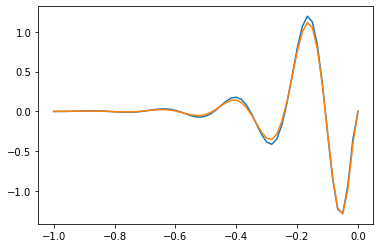

In [7]:
plt.plot(taxis, fit_cSTA)
tau = 2/(alpha+beta)
omegastar = np.sqrt(4*g-(alpha-beta)**2)/2
deltastar = np.arctan((alpha-beta)/np.sqrt(4*g-(alpha-beta)**2))
Bmp = Amp*np.sqrt(4*g)/np.sqrt(4*g-(alpha-beta)**2)
test_cSTA = NGD_TK_AS(np.abs(taxis), tau, omegastar, deltastar, tau_y, Bmp)
plt.plot(taxis, test_cSTA)

print('tau      :',2/(alpha+beta))
print('omegastar:',np.sqrt(4*g-(alpha-beta)**2)/2)
print('deltastar:',np.arctan((alpha-beta)/np.sqrt(4*g-(alpha-beta)**2)))
print('tau_y    :',tau_y)
print('Bmp      :',Amp*np.sqrt(4*g)/np.sqrt(4*g-(alpha-beta)**2))

tau      : 0.1369202907857056
omegastar: 26.790616932927794
deltastar: 0.2619755141227257
tau_y    : 0.037901674740413914
Bmp      : 5.581309730279353


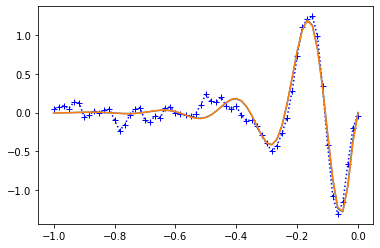

In [8]:
popt,pcov = curve_fit(NGD_TK_AS, np.abs(taxis) , cSTA, p0=[tau, omegastar, deltastar, tau_y, Bmp],
                      bounds = ([0     , 0     , 0     , 0     , 0     ],
                                [np.inf, np.inf, np.inf, 0.6   , np.inf]) )
[tau, omegastar, deltastar, tau_y, Bmp] = popt
print('tau      :',tau)
print('omegastar:',omegastar)
print('deltastar:',deltastar)
print('tau_y    :',tau_y)
print('Bmp      :',Bmp)
fit_cSTA = NGD_TK_AS(np.abs(taxis), *popt).copy()
ax.plot(taxis, fit_cSTA)
fig

# NGD2L_FBFF 

In [9]:
def NGD2L_TK(T, alpha, beta, gamma, g, h, tau_y, Amp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    y=np.zeros_like(x)
    z=np.zeros_like(x)
    w=np.zeros_like(x)
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j] + x[j]-z[j] )
        dz=dt*(-beta *z[j] + g*y[j] )
        dw=dt*(-gamma*w[j] + y[j]-h*z[j] )
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
        w[j+1]=w[j]+dw
#     print(len(w), len(w[::10]))
    return -Amp*w[::50]/(dt)#normalized by integration

In [10]:
def NGD2L_TK_AS(T, tau, gamma, omegastar, deltastar, tau_y, Bmp, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -( Bmp*np.exp(-T/tau)*np.cos(T*omegastar+deltastar) + Dmp*np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    
    return w/(dt)

alpha : 8.935550572606482
beta  : 8.796933990660524
gamma : 46.065072437533786
g     : 690.3931817857701
h     : 0.01234051787078069
tau_y : 0.021537994058893086
Amp   : 221.00586665915912


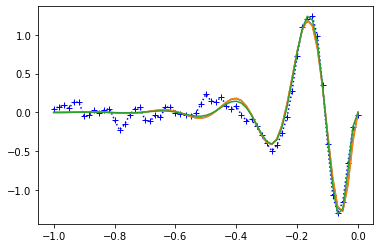

In [11]:
alpha, beta = 14.,14.
gamma = 36.
g = 680.
h = 0.01
tau_y = 0.027
Amp = 100
popt,pcov = curve_fit(NGD2L_TK, np.abs(taxis) , cSTA, p0=[alpha, beta, gamma, g, h, tau_y, Amp],
                      bounds = ([0     , 0     , 0     , 0     , 0     , 0     , 0     ],
                                [np.inf, np.inf, np.inf, np.inf, np.inf, 0.6   , np.inf]) )
[alpha, beta, gamma, g, h, tau_y, Amp] = popt
print('alpha :',alpha)
print('beta  :',beta)
print('gamma :',gamma)
print('g     :',g)
print('h     :',h)
print('tau_y :',tau_y)
print('Amp   :',Amp)
fit_cSTA = NGD2L_TK(np.abs(taxis), *popt).copy()
ax.plot(taxis, fit_cSTA)
fig

tau      : 0.11278735322533522
gamma    : 46.065072437533786
omegastar: 26.27524268482734
deltastar: -0.29903178719123413
tau_y    : 0.021537994058893086
Bmp      : 5.105407569397946
Dmp      : -4.878840648699224


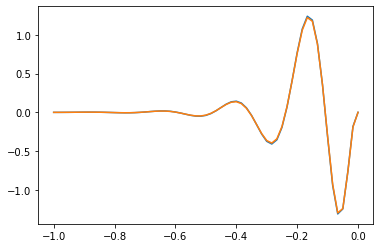

In [12]:
plt.plot(taxis, fit_cSTA)
tau = 2/(alpha+beta)
omegastar = np.sqrt(4*g-(alpha-beta)**2)/2
deltastar = np.arctan( (beta**2-2*g-alpha*beta+alpha*gamma-beta*gamma-alpha*g*h-beta*g*h+2*gamma*g*h)
                      /(np.sqrt(4*g-(alpha-beta)**2)*(-beta+gamma+g*h)) )
Bmp = Amp*np.sqrt(4*g*(-beta*h+alpha*h+g*h*h+1) / ((4*g-(alpha-beta)**2)*(g+alpha*beta-alpha*gamma-beta*gamma+gamma**2)) )
Dmp = Amp*(beta-gamma-g*h)/(g+alpha*beta-alpha*gamma-beta*gamma+gamma**2)
test_cSTA = NGD2L_TK_AS(np.abs(taxis), tau, gamma, omegastar, deltastar, tau_y, Bmp, Dmp)
plt.plot(taxis, test_cSTA)

print('tau      :',tau)
print('gamma    :',gamma)
print('omegastar:',omegastar)
print('deltastar:',deltastar)
print('tau_y    :',tau_y)
print('Bmp      :',Bmp)
print('Dmp      :',Dmp)

tau      : 0.13563438178875528
gamma    : 54553.25716365557
omegastar: 26.780422826480773
deltastar: 0.2475559113417854
tau_y    : 0.03732155396569067
Bmp      : 5.572310716944471
Dmp      : 3.28565552510912e-23


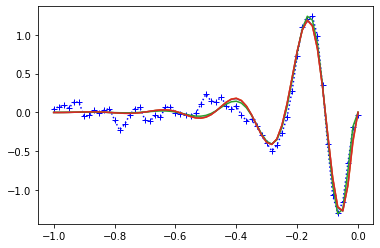

In [13]:
tau = 2/(alpha+beta)
omegastar = np.sqrt(4*g-(alpha-beta)**2)/2
deltastar = 0
Bmp = 20
Dmp = 1
popt,pcov = curve_fit(NGD2L_TK_AS, np.abs(taxis) , cSTA, p0=[tau, gamma, omegastar, deltastar, tau_y, Bmp, Dmp],
                      bounds = ([0     , 0     , 0     ,-np.pi, 0     , 0     , 0     ],
                                [np.inf, np.inf, np.inf, np.pi, 0.6   , np.inf, np.inf]) )
[tau, gamma, omegastar, deltastar, tau_y, Bmp, Dmp] = popt
print('tau      :',tau)
print('gamma    :',gamma)
print('omegastar:',omegastar)
print('deltastar:',deltastar)
print('tau_y    :',tau_y)
print('Bmp      :',Bmp)
print('Dmp      :',Dmp)
fit_cSTA = NGD2L_TK_AS(np.abs(taxis), *popt).copy()
ax.plot(taxis, fit_cSTA)
fig